In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

### Build Multi Source knowledge base with routing

##### Overview

The router pattern is a multi-agent architecture where a routing step classifies input and directs it to specialized agents, with results synthesized into a combined response. This pattern excels when your organization’s knowledge lives across distinct verticals—separate knowledge domains that each require their own agent with specialized tools and prompts.

We will build a multi-source knowledge base router that demonstrates these benefits through a realistic enterprise scenario. The system will coordinate three specialists:
- A GitHub agent that searches code, issues, and pull requests.
- A Notion agent that searches internal documentation and wikis.
- A Slack agent that searches relevant threads and discussions.


When a user asks “How do I authenticate API requests?”, the router decomposes the query into source-specific sub-questions, routes them to the relevant agents in parallel, and synthesizes results into a coherent answer.

<img src="./assets/router_based_multiagent.png" alt="Router Knowledge Base" width="600">

##### Why use a router?

The router pattern provides several advantages:
- **Parallel execution**: Query multiple sources simultaneously, reducing latency compared to sequential approaches.
- **Specialized agents**: Each vertical has focused tools and prompts optimized for its domain.
- **Selective routing**: Not every query needs every source—the router intelligently selects relevant verticals.
- **Targeted sub-questions**: Each agent receives a question tailored to its domain, improving result quality.
- **Clean synthesis**: Results from multiple sources are combined into a single, coherent response.

In [2]:
#Model options
# Initialize the LLM for use with router / structured output
from langchain.chat_models import init_chat_model
model_gemini_flash = init_chat_model("gemini-2.5-flash", model_provider="google_genai", timeout=30, temperature=0)
model_gemini_flash_lite = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai", timeout=30, temperature=0)
model_llama_groq = init_chat_model("llama-3.1-8b-instant", model_provider="groq", timeout=30, temperature=0)
model_gpt_4o_mini = init_chat_model("gpt-4o-mini", model_provider="openai", temperature=0)
model_gpt_5_nano = init_chat_model("gpt-5-nano", model_provider="openai", timeout=30, temperature=0)
model_gpt_4_dot_1 = init_chat_model("gpt-4.1", model_provider="openai", temperature=0)



### 1. Define state

- **AgentInput**: Simple state passed to each subagent (just a query)
- **AgentOutput**: Result returned by each subagent (source name + result)
- **RouterState**: Main workflow state tracking the query, classifications, results, and final answer

In [5]:
from typing import Annotated, Literal, TypedDict
import operator


class AgentInput(TypedDict):
    """Simple input state for each subagent."""
    query: str

class AgentOutput(TypedDict):
    """Output from each subagent."""
    source: str
    result: str

class Classification(TypedDict):
    """A single routing decision: which agent to call with what query."""
    source: Literal["github", "notion", "slack"]
    query: str

class RouterState(TypedDict):
    query: str
    classifications: list[Classification]
    results: Annotated[list[AgentOutput], operator.add]  # Reducer collects parallel results
    final_answer: str

#### 2. Define tools for each vertical

In [6]:
from langchain.tools import tool


@tool
def search_code(query: str, repo: str = "main") -> str:
    """Search code in GitHub repositories."""
    return f"Found code matching '{query}' in {repo}: authentication middleware in src/auth.py"


@tool
def search_issues(query: str) -> str:
    """Search GitHub issues and pull requests."""
    return f"Found 3 issues matching '{query}': #142 (API auth docs), #89 (OAuth flow), #203 (token refresh)"


@tool
def search_prs(query: str) -> str:
    """Search pull requests for implementation details."""
    return f"PR #156 added JWT authentication, PR #178 updated OAuth scopes"


@tool
def search_notion(query: str) -> str:
    """Search Notion workspace for documentation."""
    return f"Found documentation: 'API Authentication Guide' - covers OAuth2 flow, API keys, and JWT tokens"


@tool
def get_page(page_id: str) -> str:
    """Get a specific Notion page by ID."""
    return f"Page content: Step-by-step authentication setup instructions"


@tool
def search_slack(query: str) -> str:
    """Search Slack messages and threads."""
    return f"Found discussion in #engineering: 'Use Bearer tokens for API auth, see docs for refresh flow'"


@tool
def get_thread(thread_id: str) -> str:
    """Get a specific Slack thread."""
    return f"Thread discusses best practices for API key rotation"

#### 3. Create specialized agents

Create an agent for each vertical. Each agent has domain-specific tools and a prompt optimized for its knowledge source. All three follow the same pattern—only the tools and system prompt differ.

In [7]:
from langchain.agents import create_agent

model = model_llama_groq

github_agent = create_agent(
    model,
    tools=[search_code, search_issues, search_prs],
    system_prompt=(
        "You are a GitHub expert. Answer questions about code, "
        "API references, and implementation details by searching "
        "repositories, issues, and pull requests."
    ),
)

notion_agent = create_agent(
    model,
    tools=[search_notion, get_page],
    system_prompt=(
        "You are a Notion expert. Answer questions about internal "
        "processes, policies, and team documentation by searching "
        "the organization's Notion workspace."
    ),
)

slack_agent = create_agent(
    model,
    tools=[search_slack, get_thread],
    system_prompt=(
        "You are a Slack expert. Answer questions by searching "
        "relevant threads and discussions where team members have "
        "shared knowledge and solutions."
    ),
)

#### 4. Build the router workflow

Now build the router workflow using a StateGraph. The workflow has four main steps:

1. **Classify:** Analyze the query and determine which agents to invoke with what sub-questions

2. **Route:** Fan out to selected agents in parallel using Send

3. **Query agents:** Each agent receives a simple AgentInput and returns an AgentOutput

4. **Synthesize:** Combine collected results into a coherent response

In [9]:
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

router_llm = model_llama_groq

# Define structured output schema for the classifier
class ClassificationResult(BaseModel):  
    """Result of classifying a user query into agent-specific sub-questions."""
    classifications: list[Classification] = Field(
        description="List of agents to invoke with their targeted sub-questions"
    )

def classify_query(state: RouterState) -> dict:
    """Classify query and determine which agents to invoke."""
    structured_llm = router_llm.with_structured_output(ClassificationResult)  

    result = structured_llm.invoke([
        {
            "role": "system",
            "content": """Analyze this query and determine which knowledge bases to consult.
For each relevant source, generate a targeted sub-question optimized for that source.

Available sources:
- github: Code, API references, implementation details, issues, pull requests
- notion: Internal documentation, processes, policies, team wikis
- slack: Team discussions, informal knowledge sharing, recent conversations

Return ONLY the sources that are relevant to the query. Each source should have
a targeted sub-question optimized for that specific knowledge domain.

Example for "How do I authenticate API requests?":
- github: "What authentication code exists? Search for auth middleware, JWT handling"
- notion: "What authentication documentation exists? Look for API auth guides"
(slack omitted because it's not relevant for this technical question)"""
        },
        {"role": "user", "content": state["query"]}
    ])

    return {"classifications": result.classifications}

def route_to_agents(state: RouterState) -> list[Send]:
    """Fan out to agents based on classifications."""
    return [
        Send(c["source"], {"query": c["query"]})  
        for c in state["classifications"]
    ]

def query_github(state: AgentInput) -> dict:
    """Query the GitHub agent."""
    result = github_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "github", "result": result["messages"][-1].content}]}


def query_notion(state: AgentInput) -> dict:
    """Query the Notion agent."""
    result = notion_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "notion", "result": result["messages"][-1].content}]}


def query_slack(state: AgentInput) -> dict:
    """Query the Slack agent."""
    result = slack_agent.invoke({
        "messages": [{"role": "user", "content": state["query"]}]  
    })
    return {"results": [{"source": "slack", "result": result["messages"][-1].content}]}


def synthesize_results(state: RouterState) -> dict:
    """Combine results from all agents into a coherent answer."""
    if not state["results"]:
        return {"final_answer": "No results found from any knowledge source."}

    # Format results for synthesis
    formatted = [
        f"**From {r['source'].title()}:**\n{r['result']}"
        for r in state["results"]
    ]

    synthesis_response = router_llm.invoke([
        {
            "role": "system",
            "content": f"""Synthesize these search results to answer the original question: "{state['query']}"

- Combine information from multiple sources without redundancy
- Highlight the most relevant and actionable information
- Note any discrepancies between sources
- Keep the response concise and well-organized"""
        },
        {"role": "user", "content": "\n\n".join(formatted)}
    ])

    return {"final_answer": synthesis_response.content}

#### 5. Compile the workflow

Now assemble the workflow by connecting nodes with edges. 

The key is using add_conditional_edges with the routing function to enable parallel execution:

In [10]:
workflow = (
    StateGraph(RouterState)
    .add_node("classify", classify_query)
    .add_node("github", query_github)
    .add_node("notion", query_notion)
    .add_node("slack", query_slack)
    .add_node("synthesize", synthesize_results)
    .add_edge(START, "classify")
    .add_conditional_edges("classify", route_to_agents, ["github", "notion", "slack"])
    .add_edge("github", "synthesize")
    .add_edge("notion", "synthesize")
    .add_edge("slack", "synthesize")
    .add_edge("synthesize", END)
    .compile()
)

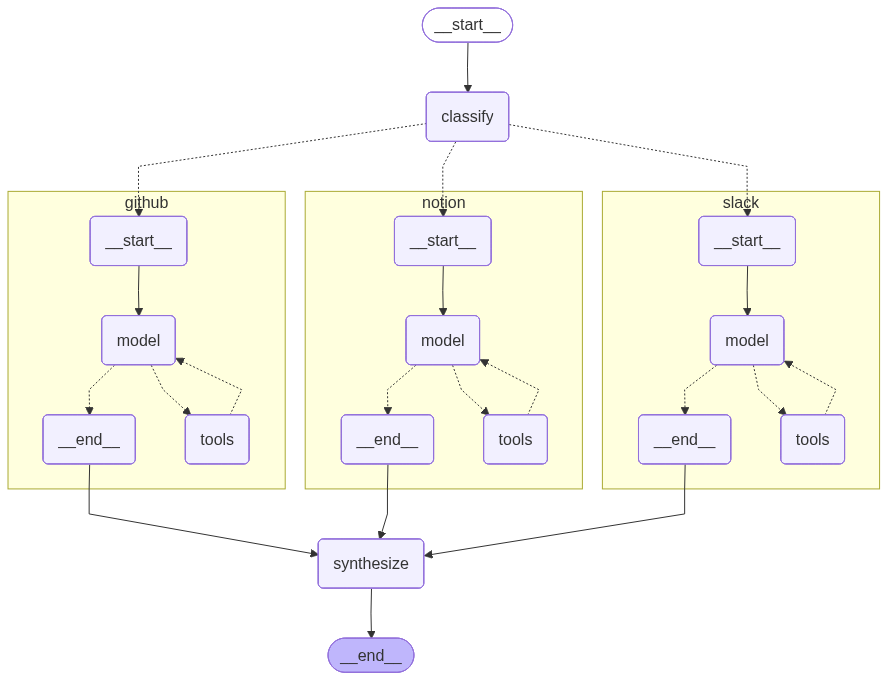

In [11]:
# Run the workflow
from IPython.display import Image, display

display(Image(workflow.get_graph(xray=True).draw_mermaid_png()))

#### 9. Advanced: Stateful routers

The router we’ve built so far is stateless—each request is handled independently with no memory between calls. For multi-turn conversations, you need a stateful approach.

##### Tool wrapper approach
The simplest way to add conversation memory is to wrap the stateless router as a tool that a conversational agent can call:

In [13]:
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_knowledge_base(query: str) -> str:
    """Search across multiple knowledge sources (GitHub, Notion, Slack).

    Use this to find information about code, documentation, or team discussions.
    """
    result = workflow.invoke({"query": query})
    return result["final_answer"]

conversational_agent = create_agent(
    model,
    tools=[search_knowledge_base],
    system_prompt=(
        "You are a helpful assistant that answers questions about our organization. "
        "Use the search_knowledge_base tool to find information across our code, "
        "documentation, and team discussions."
    ),
    checkpointer=InMemorySaver(),
)

In [ ]:
config = {"configurable": {"thread_id": "user-123"}}

result = conversational_agent.invoke(
    {"messages": [{"role": "user", "content": "How do I authenticate API requests?"}]},
    config
)
print(result["messages"][-1].content)

#### 10. Key takeaways

The router pattern excels when you have:
- **Distinct verticals**: Separate knowledge domains that each require specialized tools and prompts

- **Parallel query needs**: Questions that benefit from querying multiple sources simultaneously

- **Synthesis requirements**: Results from multiple sources need to be combined into a coherent response


The pattern has three phases: **decompose** (analyze the query and generate targeted sub-questions), **route** (execute queries in parallel), and **synthesize** (combine results).